<a href="https://colab.research.google.com/github/aditya-shriwastava/ai-notebooks/blob/master/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster RCNN

## Backbone
> **Input:** Image tensor of shape (C,H,W) in RGB order<br>
> **Output:** Feature map of shape (Cf, Hf, Wf)

1. Pre process Input Image
  1. Normalize the input image with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] 
  2. Rescale the image such that shorter side in 300 pixels.
2. Get Feature map: Pass the pre processed image to resnet backbone
  1. resnet backbone: only conv layers, not fully connected layer at the end
  2. output: feature map of shape (Cf, Hf, Wf)

## RPN (Region Proposal Network)
> **Input:** Feature map of shape (Cf, Hf, Wf), Ground truth bounding boxes<br>
> **Output:** ROIs (i.e. Region of Interests)

1. Pass feature map to 3x3 convolution to reduce depth to 512 while conserving Hf and Wf.
  - stride=1 and padding=1
  - output: feature map of shape (512, Hf, Wf)
2. Pass above output to two 1x1 convolution to get objectness score and bounding box coordinate offset.
  1. Objectness score: (2 x 9, Hf, Wf)
    - Number of anchors: 9
    - (object score + not object score) per anchors: 2
  2. Bbox offset coordinate: (4 x 9, Hf, Wf)
    - Number of anchors: 9
    - Number of param for bbox offset for 1 anchors: 4
3. Calculate all object proposal bbox
  1. Calculate all anchors coordinate.
    - Total number of anchors: 9 x Hf x Wf
  2. Use anchors coordinate and offset coordinates to get object proposals
4. For every object proposal find the corresponding ground truth bbox and calculate IoU (Intersection over Union with it)
5. Filter object proposals to generate training data for training the region proposal network.
  1. Assign negative and positive labels to object proposals based on the following:
    1. Assign positive label to:
      - object proposals with highest IoU with corresponding ground truth bbox.
      - object proposal with IoU higher than 0.7 with corresponding ground truth bbox.
    2. Assign negitave label to:
      - object proposal with IoU less than 0.3 with corresponding ground truth bbox.
  2. Randomly sample 256 object proposals with positive and negative label ratio upto 1:1.
    - If there are fewer than 128 positive samples than pad the mini-batch with negative ones.
6. Calculate the rpn loss (loss = objectness classification loss +  lambda x regression loss) and take one gradient step.
  1. objectness classification loss: negative log likelihood loss
  2. regression loss: smooth L1 loss for positive labels only

## Fast RCNN
> **Input:** Feature map of shape (Cf, Hf, Wf), ROIs, Ground truth bounding box coordinate and label<br>
> **Output:** Object detection bbox and label

1. Project ROIs from image to feature map.
2. Perform ROI pooling on projected feature map to obtain fixed size representation corresponding to each ROIs.
3. Pass the output of above to some FC layers for procession.
4. Pass the output of above to two FC layers:
    1. For object classification.
    2. Bbox regression: Fine tuning ROIs coordinate to obtain detection.
5. Calculate the fast rcnn loss (loss = object classification loss + lambda x regression loss) and take one gradient step.
    1. object classification loss: negative log likelihood loss over K object classes (including background)
    2. regression loss: smooth L1 loss for positive labels only
6. Use NMS to filter out redundant detection.


In [20]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [59]:
#@title Load VOC data
train_data = torchvision.datasets.VOCDetection(
  root="./datasets", year="2012",
  image_set='train', download=True,
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])
)
train_loader = DataLoader(train_data, batch_size=1, shuffle=False)

val_data = torchvision.datasets.VOCDetection(
  root="./datasets", year="2012",
  image_set='val', download=True,
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])
)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)

voc_labels = ("background",
  "aeroplane", "bicycle", "bird", "boat","bottle",
  "bus", "car", "cat", "chair", "cow",
  "diningtable", "dog", "horse", "motorbike", "person",
  "pottedplant", "sheep", "sofa", "train", "tvmonitor"
)

voc_label_to_id = {k: v+1 for v, k in enumerate(voc_labels)}
voc_label_to_id['background'] = 0

Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets


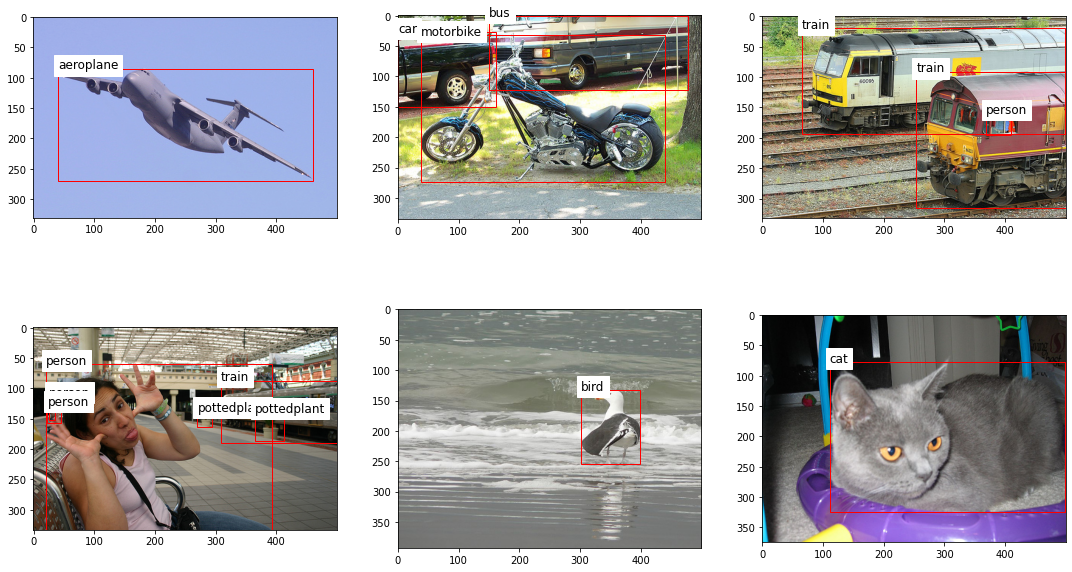

In [22]:
#@title Show sample train data
## 1. Randomly sample list of 6 datapoints
datapoints  = np.random.randint(0, len(train_data)-1, 6)
imgs = [torchvision.transforms.ToPILImage()(train_data[i][0]) for i in datapoints]
metadatas = [train_data[i][1] for i in datapoints]

## 2. Display sampled data
fig, axarr = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
for index, (img, metadata) in enumerate(zip(imgs, metadatas)):
  i = index // 3
  j = index - (i * 3)
  axarr[i,j].imshow(imgs[index])
  for obj in metadata['annotation']['object']:
    label = obj['name']
    xmin = int(obj['bndbox']['xmin'])
    ymin = int(obj['bndbox']['ymin'])
    width = int(obj['bndbox']['xmax']) - xmin
    height = int(obj['bndbox']['ymax']) - ymin
    axarr[i,j].add_patch(patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none'))
    axarr[i,j].text(xmin, ymin, label, fontsize = 12, color='black', backgroundcolor='white')
plt.show()

In [104]:
#@title bbox utils
"""
Formats:
1. minmax: [xmin, ymin, xmax, ymax]
2. minwh: [xmin, ymin, width, height]
3. ctrwh: [xctr, yctr, width, height]
"""
def minmax_to_minwh(bbox):
  bbox[2:] -= bbox[:2]

def minmax_to_ctrwh(bbox):
  bbox[2:] -= bbox[:2]
  bbox[:2] += bbox[2:]/2 

def minwh_to_minmax(bbox):
  bbox[2:] += bbox[:2]

def ctrwh_to_minmax(bbox):
  bbox[:2] -= bbox[2:]/2
  bbox[2:] += bbox[:2]

def test_bbox_utils():
  bbox = np.array([50.,20.,100.,200.])
  minmax_to_minwh(bbox)
  assert((bbox == np.array([50., 20., 50., 180.])).all())

  bbox = np.array([50.,20.,100.,200.])
  minwh_to_minmax(bbox)
  assert((bbox == np.array([50., 20., 150., 220.])).all())

  bbox = np.array([50.,20.,100.,200.])
  minmax_to_ctrwh(bbox)
  assert((bbox == np.array([75, 110, 50, 180])).all())

  bbox = np.array([100.,200.,20.,40.])
  ctrwh_to_minmax(bbox)
  assert((bbox == np.array([90., 180., 110., 220.])).all())

test_bbox_utils()

In [23]:
class FastRCNN(nn.Module):
  def __init__(self):
    pass

class RPN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lower_dim_mapping = nn.conv2d(2048, 512, 3, stride=1, padding=1)
    self.objectness_score = nn.conv2d(512, 2*9, 1, stride=1, padding=1)
    self.anchor_offset= nn.conv2d(512, 4*9, 1, stride=1, padding=1)
    
  def forward(self, feature_map, bboxs):
    feature_map = self.lower_dim_mapping(feature_map)
    objectness_score = self.objectness_score(feature_map)
    anchor_offset = self.anchor_offset(feature_map)

  def get_anchors(self, Hf, Wf):
    pass

class FasterRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet50 = torchvision.models.resnet50(pretrained=True)
    self.backbone = nn.Sequential(
        self.resnet50.conv1,
        self.resnet50.bn1,
        self.resnet50.relu,
        self.resnet50.maxpool,
        self.resnet50.layer1,
        self.resnet50.layer2,
        self.resnet50.layer3,
        self.resnet50.layer4)
    self.rpn = RPN()
    sef.fast_rcnn = FastRCNN()
    
  def forward(self, img):
    return self.resnet_base(img)

  def preprocess(self, img, bboxs):
    # 1. Resize the Image 
    _, H, W = img.shape
    img = torchvision.transforms.Resize(300)(img)
    _, H_, W_ = img.shape

    # 2. Resize the bboxs according to image resize
    bboxs = bboxs * [W_/W, H_/H, W_/W, H_/H]

    # 3. Normalize the the image
    normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    img = normalize(img)
    return img, bboxs

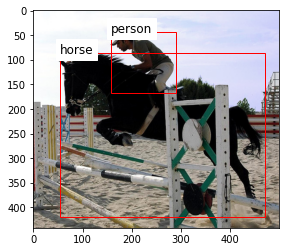

torch.Size([1, 2048, 14, 16])


In [106]:
def get_bboxs_and_labels(meta):
  objects = meta['annotation']['object']
  bboxs = []
  labels = []
  ids = []
  for object_ in objects:
    labels.append(object_['name'][0])
    ids.append(voc_label_to_id[labels[-1]])
    xmin = int(object_['bndbox']['xmin'][0])
    ymin = int(object_['bndbox']['ymin'][0])
    xmax = int(object_['bndbox']['xmax'][0])
    ymax = int(object_['bndbox']['ymax'][0])
    bboxs.append([xmin, ymin, xmax, ymax])
  return np.array(bboxs, dtype=np.float32), labels, ids

def disp(img, bboxs, labels):
  img = torchvision.transforms.ToPILImage()(img)
  fig, ax = plt.subplots()
  ax.imshow(img)
  for bbox, label in zip(bboxs, labels):
    bbox = np.copy(bbox)
    minmax_to_minwh(bbox)
    ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none'))
    ax.text(bbox[0], bbox[1], label, fontsize = 12, color='black', backgroundcolor='white')
  plt.show()

# Training
for img, meta in train_loader:
  img = img[0]
  bboxs, labels, ids = get_bboxs_and_labels(meta)
  disp(img, bboxs, labels)
  model = FasterRCNN()
  print(model(img.unsqueeze(0)).shape)
  break